In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
os.sys.path.append('../data/scripts/')
os.sys.path.append('../evaluation/')
from create_training_data_lib import random_mixture_sample, plot_2d_mixture, plot_cov_ellipse, correlation_to_covariance

from scipy.stats import multivariate_normal
import matplotlib as mpl
from matplotlib import patches
from matplotlib import lines
from matplotlib.colors import LinearSegmentedColormap


In [2]:
# function for creating a custom color map
def get_custom_cmap(name, max_alpha=1.0):
    base_cmap = plt.get_cmap(name)
    n = 256  # Number of discrete colors
    max_alpha = np.min([1, max_alpha])
    alphas = np.linspace(0, max_alpha, n)
    custom_cmap = LinearSegmentedColormap.from_list(
        'Reds_with_alpha',
        [(base_cmap(i / n)[:3] + (alphas[i],)) for i in range(n)],
        N=n
    )
    return custom_cmap


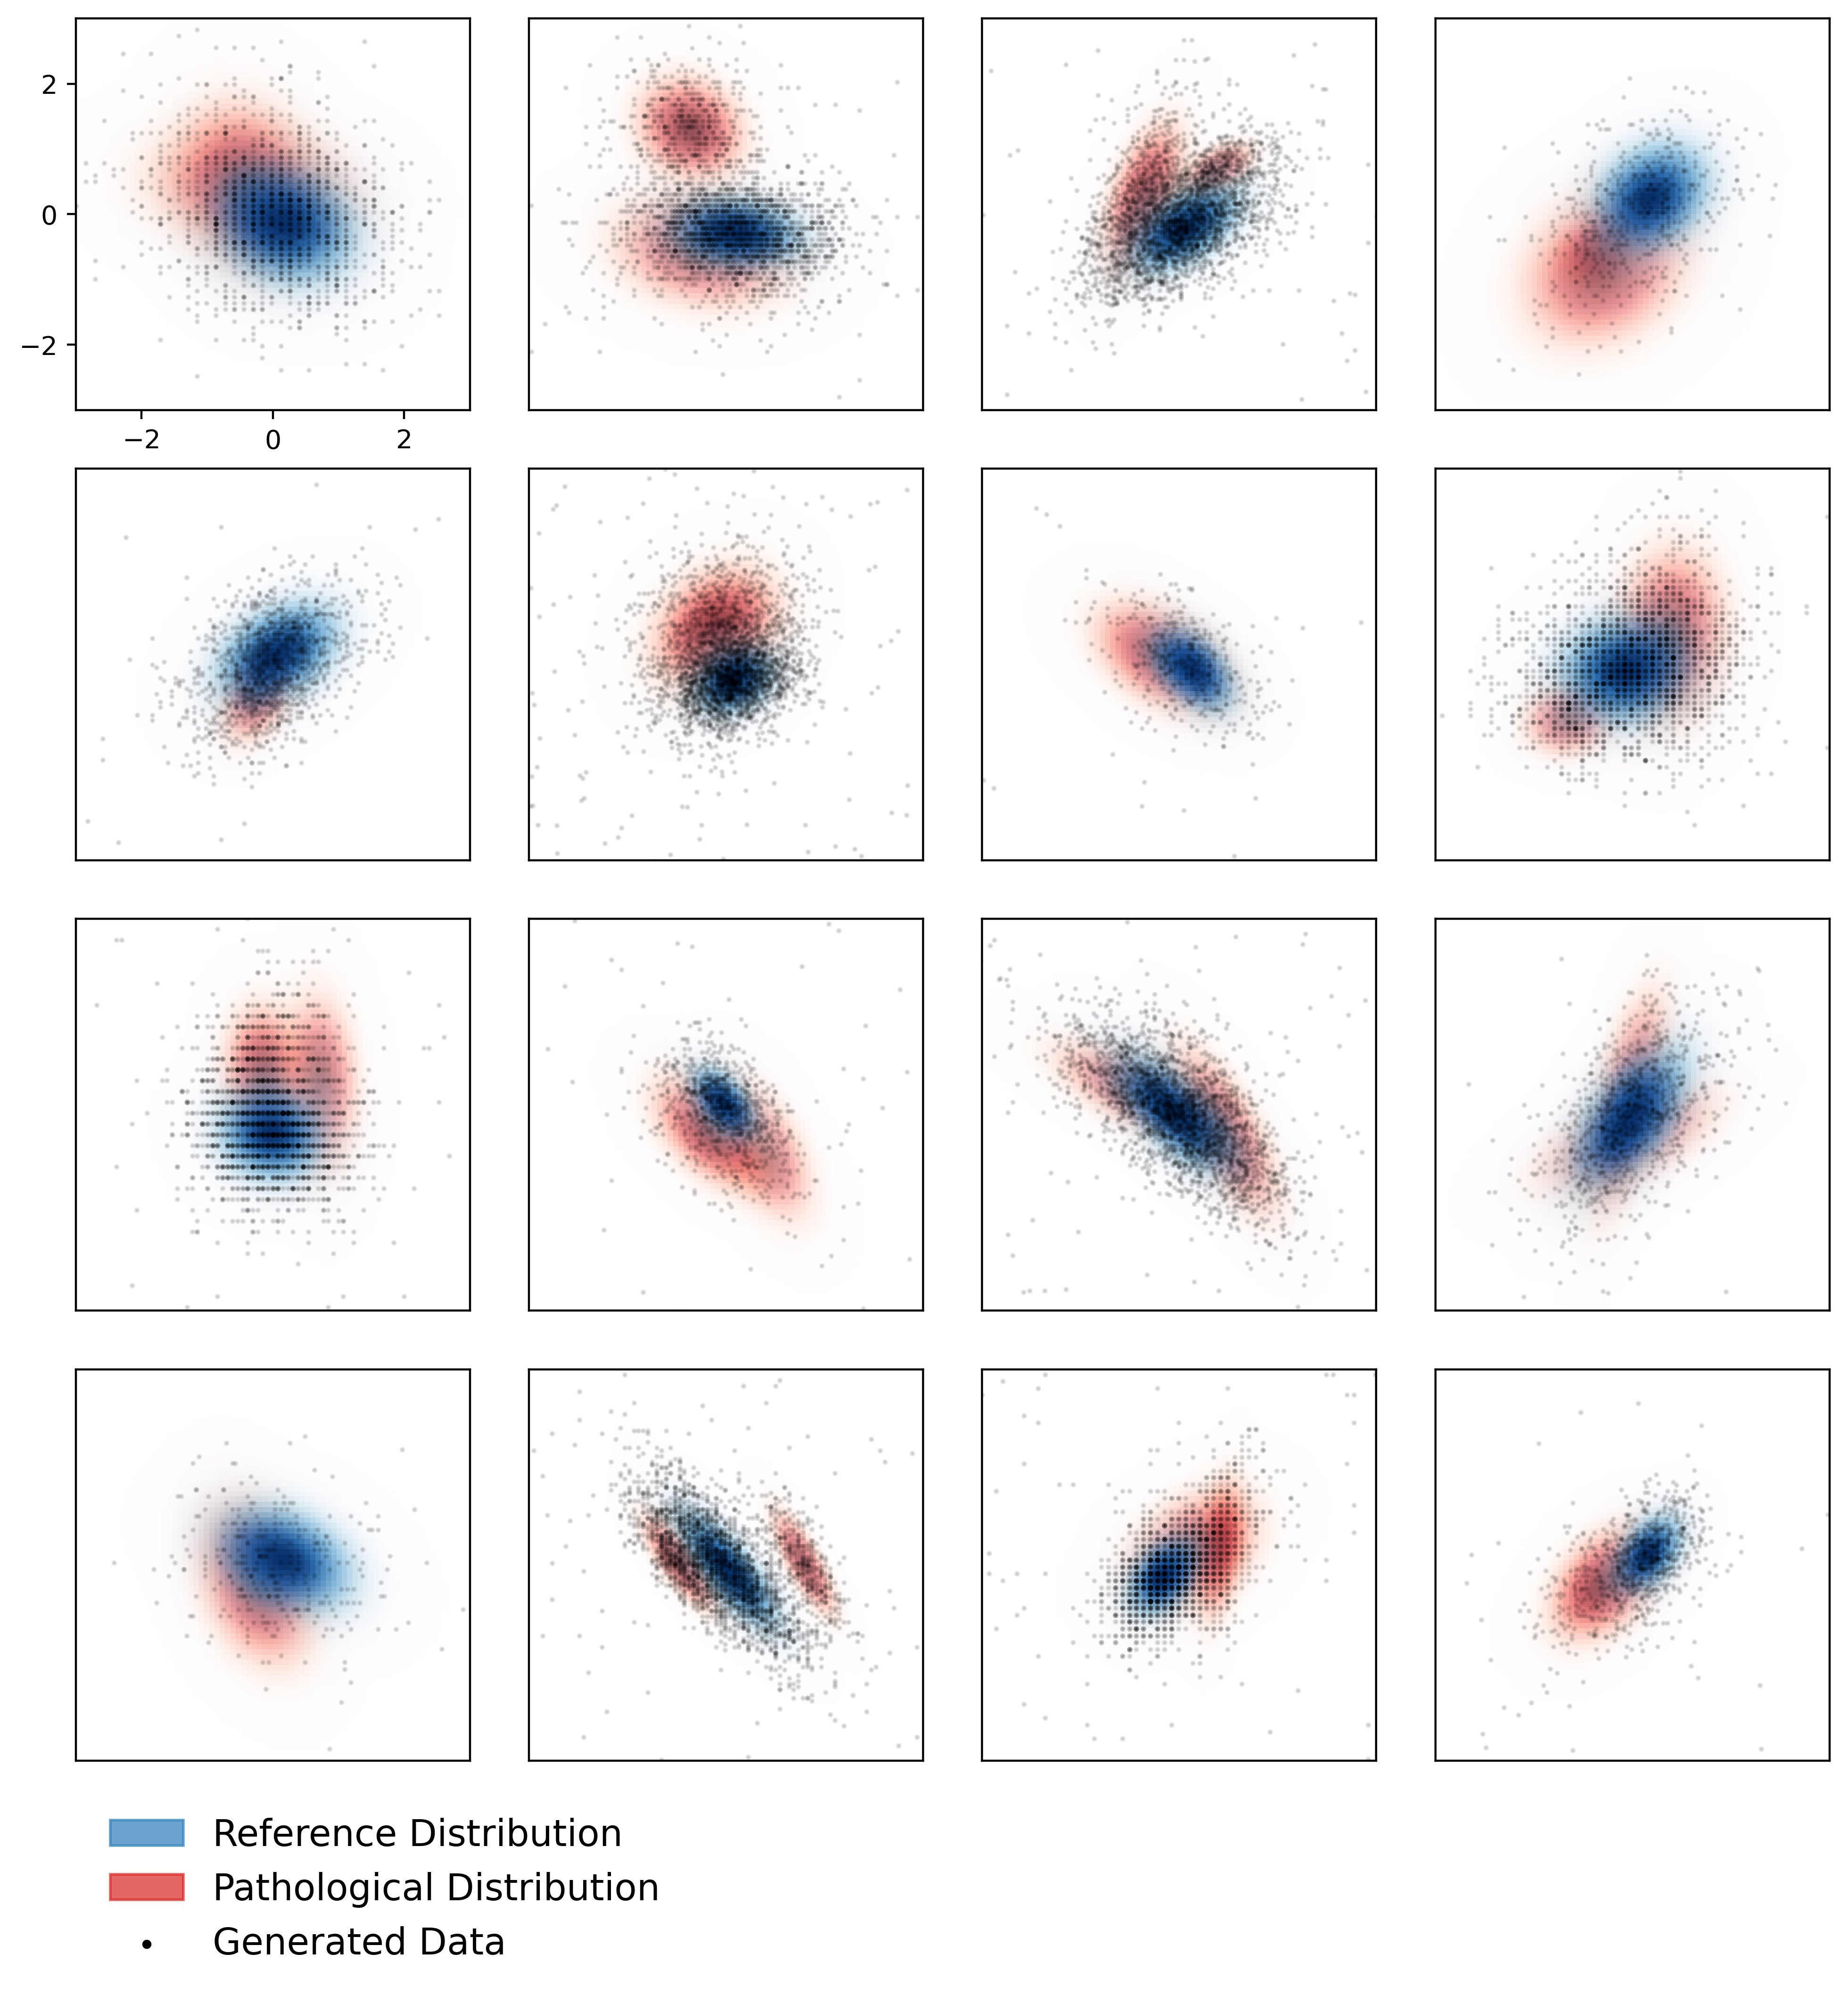

In [ ]:
# plot 2D examples

x_grid, y_grid = np.mgrid[-4 : 4 : 100j, -4 : 4 : 100j,]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
    
nc = 4
nr = 4
plot_size = 3
spacing = 0.15
scope = [-3, 3]
plt.figure(figsize=(plot_size*nc, plot_size*nr), dpi=400)
for nplt in range(nc*nr):
    
    # sample from random Gaussian mixture
    sample, mean_vectors, std_devs, corr_mats, comps, sizes = random_mixture_sample(
        n_dimensions = 2,
        n_components = np.random.choice([1,2]),
        n_samples = np.random.uniform(250, 3000),
        p_frac_range = [0.3, 0.3],
        quantize_step = np.random.choice([0, 0.05, 0.1, 0.2]),
    )
    cov_mats = [correlation_to_covariance(i,j) for i,j in zip(corr_mats, std_devs)]
        
    # standardize
    a = 1/sample.std(axis=0) # reciprocal of sample std for scaling
    b = -sample.mean(axis=0) # negative of sample mean for shifting
    for i in range(len(cov_mats)):
        cov_mats[i] = [
            [cov_mats[i][0,0]*a[0]**2, cov_mats[i][0,1]*a[0]*a[1]],
            [cov_mats[i][1,0]*a[0]*a[1], cov_mats[i][1,1]*a[1]**2]
        ]
    mean_vectors = [a*(i+b) for i in mean_vectors]
    sample = a*(sample+b)
    
    # update subplot
    plt.subplot(nr, nc, nplt+1)
        
    # plot contours
    for i in range(len(set(comps))-2, -1, -1):
        pdf = multivariate_normal(mean_vectors[i], cov_mats[i]).pdf(positions).reshape(x_grid.shape)
        pdf = (pdf-pdf.min())/(pdf.max()-pdf.min())
        pdf[pdf<=0.01] = np.nan
        weight = sizes[i]/sum(sizes)
        weight_shift = 0.5
        if i==0:
            plt.pcolormesh(x_grid, y_grid, pdf, cmap=get_custom_cmap('Blues', weight+weight_shift))
        else:
            plt.pcolormesh(x_grid, y_grid, pdf, cmap=get_custom_cmap('Reds', weight+weight_shift))
            
    # plot scatter points
    plt.scatter(sample[:,0], sample[:,1], s=5, c='k', marker='.', alpha=0.1)
    
    # legend
    if nplt==nc*(nr-1):
        plt.gca().add_patch(patches.Rectangle((0, 0), 0, 0, color=get_custom_cmap('Blues')(0.7), label='Reference Distribution'))
        plt.gca().add_patch(patches.Rectangle((0, 0), 0, 0, color=get_custom_cmap('Reds')(0.7), label='Pathological Distribution'))
        plt.scatter([], [], s=25, c='k', marker='.', alpha=1, label='Generated Data')        
        plt.gca().legend(loc=(0.05, -0.55), fontsize=14, frameon=False)
            
    # subplot formatting
    plt.xlim(scope)
    plt.ylim(scope)
    plt.xticks([-2, 0, 2])
    plt.yticks([-2, 0, 2])
    if nplt>0:
        plt.xticks([])
        plt.yticks([])
    spacing = 0.15
        
# total formatting
plt.subplots_adjust(wspace=spacing, hspace=spacing)
